# Import Packages

In [99]:
#standard packages
from __future__ import print_function, division
import numpy as np
import pandas as pd
import pylab as pl

# Special packages
import geopandas as gp
from geopy.geocoders import Nominatim
#import geopy as gpy
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.stats as st
import seaborn  as sns
import os
import json

# Inline plotting
% pylab inline

# NB set random seed for repeatability if any random datasets
np.random.seed(100)

Populating the interactive namespace from numpy and matplotlib


# Import Data 
### Cape Town Water Consumption Data

In [100]:
AnnualWater = pd.read_excel('https://github.com/andrewnell/PUI2017_adn323/raw/master/HW8_adn323/Annual%20average%20water%20consumption%20report%20for%20Cape%20Town%20suburbs%20April%202017%20(1).xlsx')
print(AnnualWater.shape)
AnnualWater.head()

(14820, 30)


,Suburb,Value,Units,ReportDate,BUS_COMM,CLUSTER,EDUCATION,EXTERNAL,FARM_AH,FLATS,...,RES_1000,RES_1500,RES_2000,RES_GT_2000,SERVITUDE,UNKNOWN,LARGE,TOTAL_Excl_Losses,LOSSES_Theoretical,TOTAL_Incl_Theoretical_Losses
0,ACACIA PARK,Connections,(no.),2017-04-01,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2.0,5.0,0.0,5.0
1,ACACIA PARK,Meters,(no.),2017-04-01,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2.0,5.0,0.0,5.0
2,ACACIA PARK,Units (Metered Supply),(no.),2017-04-01,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.0,4.0,0.0,4.0
3,ACACIA PARK,Units (Estimated Supply),(no.),2017-04-01,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,ACACIA PARK,Units (Total),(no.),2017-04-01,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0,1.0,27.0,0.0,27.0


Note data is for all building types by suburb, this needs to be sorted and the data organised into a more processable format

### Cape Town Median Residential Property Valuations by Suburb
Data can be used to estimate income in area, particuarly given economic spatial divide 

In [101]:
MedValue = pd.read_excel('https://github.com/andrewnell/PUI2017_adn323'\
                         '/raw/master/HW8_adn323/Valuation%20suburbs%'\
                         '202012%20and%202015.xlsx',header=1).reset_index()
print(MedValue.shape)
MedValue.head()

(769, 6)


,index,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2012_VAL,GV2015_VAL
0,ACACIA PARK,NaN,NaN,NaN,NaN,NaN
1,ADMIRALS PARK,401.0,235.0,111.0,680000.0,760000.0
2,ADRIAANSE,378.0,127.0,65.0,400000.0,470000.0
3,AIRPORT CITY,NaN,NaN,NaN,NaN,NaN
4,AMANDA GLEN - Bellville,102.0,1032.0,310.0,1680000.0,2000000.0


# Clean and Process Data
### Cape Town Water Consumption Data

In [102]:
###############################################################################
# Remove irrlevant columns
AnnualWater.drop(['ReportDate','BUS_COMM','EDUCATION', 'EXTERNAL',
                  'FARM_AH','GOV_INST','IGNORE','INDUSTRIAL','NO_CATEGORY',
                  'OTHER','PARKS', 'SERVITUDE', 'UNKNOWN', 'LARGE'], 
                 axis=1, inplace=True) 

# Remove Ireelevant Rows
AnnualWater = AnnualWater[~AnnualWater['Value'].str.contains('Connections|'\
                                                             'Meters|Metered'\
                                                             '|Vacant|'\
                                                             'Estimated|AADD|'\
                                                             'Demand')]
AnnualWater = AnnualWater[~AnnualWater['Suburb'].str.contains('TOTAL')] # Remove Total rows

# Review data
AnnualWater.head()

,Suburb,Value,Units,CLUSTER,FLATS,INFORMAL,HOUSING,RES_1,RES_500,RES_1000,RES_1500,RES_2000,RES_GT_2000,TOTAL_Excl_Losses,LOSSES_Theoretical,TOTAL_Incl_Theoretical_Losses
4,ACACIA PARK,Units (Total),(no.),0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0
8,ACACIA PARK,Stands (Total),(no.),0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0
11,ACACIA PARK,Consumption (Total),(kL),0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,27068.0,6767.0,33835.0
23,ADMIRALS PARK,Units (Total),(no.),10.0,9.0,0.0,0,0.0,329.0,102.0,0.0,0.0,2.0,478.0,0.0,478.0
27,ADMIRALS PARK,Stands (Total),(no.),6.0,3.0,0.0,0,0.0,329.0,102.0,0.0,0.0,2.0,468.0,0.0,468.0


In [103]:
# Create new data column for Total for Residential
AnnualWater['TotalRes'] = (AnnualWater['CLUSTER'] + AnnualWater['FLATS'] + 
                             AnnualWater['INFORMAL'] + AnnualWater['RES_1'] + 
                             AnnualWater['RES_500'] + AnnualWater['RES_1000']
                             + AnnualWater['RES_2000']+ 
                             AnnualWater['RES_GT_2000'])

In [104]:
# pivot table to destructure flat file into neat columns
AnnualWater = AnnualWater.pivot(index='Suburb', columns='Value', 
                                values='TotalRes').reset_index()

# Rename Columns to easy format
AnnualWater.rename(columns={'Consumption (Total)':'Consumption_kL',
                            'Stands (Total)':'stands',
                            'Units (Total)':'units'},inplace=True)

# Review Data
AnnualWater.head()

Value,Suburb,Consumption_kL,stands,units
0,ACACIA PARK,0.0,0.0,0.0
1,ADMIRALS PARK,38540.0,442.0,452.0
2,ADRIAANSE,257458.0,396.0,753.0
3,AIRPORT CITY,2240.0,5.0,5.0
4,AMANDA GLEN - Bellville,15291.0,12.0,121.0


In [105]:
# Create Consumption per Unit column
AnnualWater['ConsPerUnit'] = AnnualWater['Consumption_kL'] / AnnualWater['units']
AnnualWater = AnnualWater.dropna(subset=["ConsPerUnit"])

# Review Data
AnnualWater.head()

Value,Suburb,Consumption_kL,stands,units,ConsPerUnit
1,ADMIRALS PARK,38540.0,442.0,452.0,85.265487
2,ADRIAANSE,257458.0,396.0,753.0,341.909695
3,AIRPORT CITY,2240.0,5.0,5.0,448.000000
4,AMANDA GLEN - Bellville,15291.0,12.0,121.0,126.371901
5,AMANDA GLEN - Durbanville,10362.0,39.0,56.0,185.035714


In [106]:
# Review data and identify any potential outliers
AnnualWater.describe()

Value,Consumption_kL,stands,units,ConsPerUnit
count,7.290000e+02,729.000000,729.000000,729.000000
mean,1.727784e+05,917.078189,1114.348422,196.611614
std,3.034750e+05,1653.913858,1873.697328,266.205975
min,0.000000e+00,1.000000,1.000000,0.000000
25%,1.777000e+04,78.000000,110.000000,130.829948
50%,6.337000e+04,333.000000,439.000000,165.393798
75%,2.041300e+05,977.000000,1343.000000,198.796667
max,4.051716e+06,22677.000000,22687.000000,4213.000000


In [107]:
AnnualWater[AnnualWater['ConsPerUnit'] <20]

Value,Suburb,Consumption_kL,stands,units,ConsPerUnit
10,ANNANDALE FARM,0.0,49.0,49.0,0.000000
57,BELHAR EXT 8,2548.0,42.0,305.0,8.354098
91,BONGANI,0.0,1.0,1.0,0.000000
103,BOTTELARY SMALLHOLDINGS 2,40.0,258.0,259.0,0.154440
119,BROADLANDS,0.0,1.0,1.0,0.000000
138,CASTLE ROCK,0.0,28.0,28.0,0.000000
206,EENSGEVONDEN,0.0,10.0,10.0,0.000000
208,EERSTERIVIER INDUSTRIA,0.0,101.0,101.0,0.000000
221,ENKANINI INFORMAL SETTLEMENT,0.0,1456.0,1456.0,0.000000
233,FAIRDALE,48283.0,3862.0,3862.0,12.502071


In [108]:
# Remove outliers
AnnualWater = AnnualWater[(AnnualWater['ConsPerUnit'] < 300) & (AnnualWater['ConsPerUnit'] > 75)]
AnnualWater = AnnualWater[(AnnualWater['Consumption_kL'] < 800000) & (AnnualWater['Consumption_kL'] > 1000)]

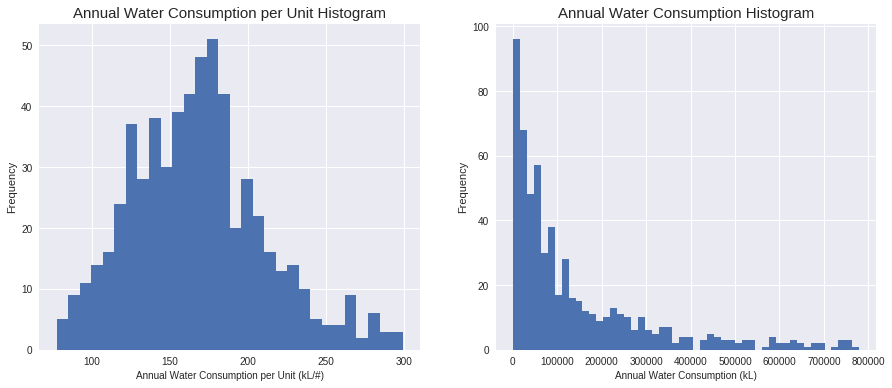

In [109]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Histogram
pl.subplot(121)
pl.hist(AnnualWater['ConsPerUnit'], bins = 30)

# Format Chart
pl.xlabel("Annual Water Consumption per Unit (kL/#)",fontsize=10)
pl.ylabel("Frequency")
pl.title("Annual Water Consumption per Unit Histogram",fontsize=15,)

# Plot Histogram
pl.subplot(122)
pl.hist(AnnualWater['Consumption_kL'], bins = 50)

# Format Chart
pl.xlabel("Annual Water Consumption (kL)",fontsize=10)
pl.ylabel("Frequency")
pl.title("Annual Water Consumption Histogram",fontsize=15)

#### Figure 1 and 2: Histogram of Annual Water Consumption per unit and Annual Water Consumption and in each suburb

In [110]:
AnnualWater.describe()

Value,Consumption_kL,stands,units,ConsPerUnit
count,593.000000,593.000000,593.000000,593.000000
mean,143624.274874,751.795953,924.146712,168.261876
std,167511.101484,997.334524,1142.912434,43.226440
min,1007.000000,1.000000,5.000000,77.743265
25%,26600.000000,116.000000,161.000000,137.560618
50%,76585.000000,376.000000,483.000000,166.742255
75%,202271.000000,942.000000,1267.000000,192.845528
max,779280.000000,6450.000000,6450.000000,299.035827


### Median Residential Property Valuation Data

In [111]:
# Create Column for Value per square meter
MedValue['Value15PerM2'] = (MedValue['GV2015_VAL'] / 
                            MedValue['MED_LAND_EXTENT/m2'])

# Drop Irelevant Columns
MedValue.drop(['NUM_RES_PROP','MED_LAND_EXTENT/m2',
               'MED_TOT_BLD_AREA/m2','GV2012_VAL'],
              axis=1,inplace=True)

# Review Data
MedValue.head()

,index,GV2015_VAL,Value15PerM2
0,ACACIA PARK,NaN,NaN
1,ADMIRALS PARK,760000.0,3234.042553
2,ADRIAANSE,470000.0,3700.787402
3,AIRPORT CITY,NaN,NaN
4,AMANDA GLEN - Bellville,2000000.0,1937.984496


In [112]:
# Drop NAs
MedValue.dropna(inplace=True)

In [113]:
MedValue.head()

,index,GV2015_VAL,Value15PerM2
1,ADMIRALS PARK,760000.0,3234.042553
2,ADRIAANSE,470000.0,3700.787402
4,AMANDA GLEN - Bellville,2000000.0,1937.984496
5,AMANDA GLEN - Durbanville,2000000.0,1897.533207
6,AMANDELRUG,1450000.0,1473.577236


In [114]:
MedValue.describe()

,GV2015_VAL,Value15PerM2
count,6.490000e+02,649.000000
mean,1.495929e+06,2569.985483
std,1.775804e+06,2844.320117
min,5.600000e+04,46.340466
25%,4.900000e+05,1445.663011
50%,1.050000e+06,1937.984496
75%,1.900000e+06,2748.344371
max,1.905000e+07,40575.079872


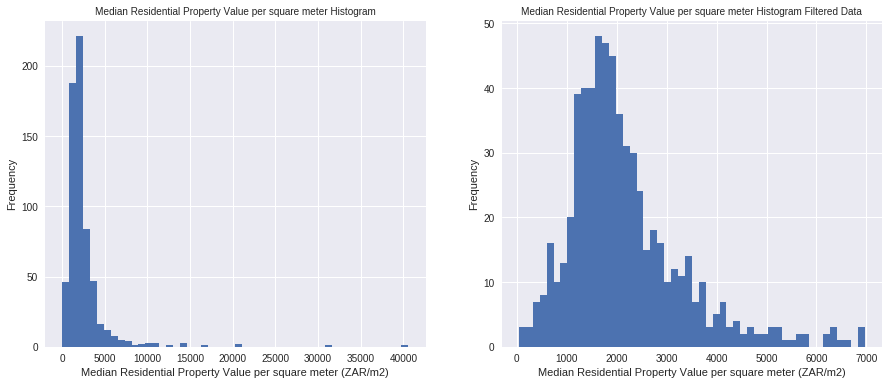

In [117]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Histogram 
pl.subplot(121)
pl.hist(MedValue['Value15PerM2'], bins = 50)

# Format Plot
pl.xlabel("Median Residential Property Value per square meter (ZAR/m2)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value per square meter Histogram",fontsize=10,)

# Plot Filtered Histogram to understand data better
pl.subplot(122)
pl.hist(MedValue[MedValue['Value15PerM2'] < 7000]['Value15PerM2'], bins = 50)

# Format Plot
pl.xlabel("Median Residential Property Value per square meter (ZAR/m2)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value per square meter Histogram Filtered Data",fontsize=10,)

#### Figure 3 nd 4: Histograms of Median Residential Property Value per sqyuare meter before and after cleaning

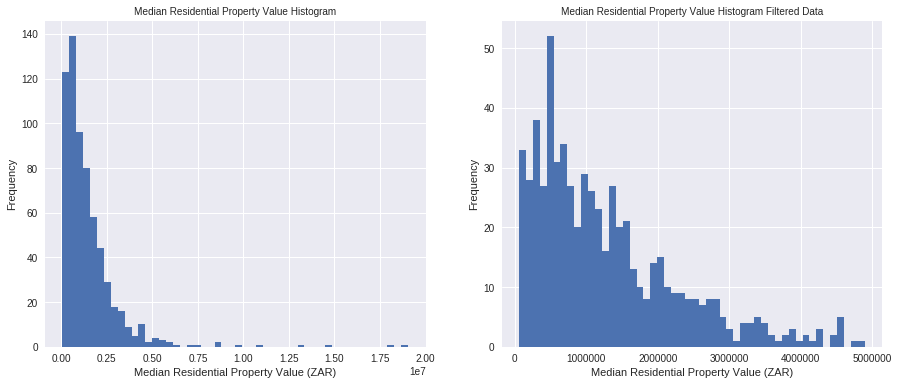

In [116]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Histogram 
pl.subplot(121)
pl.hist(MedValue['GV2015_VAL'], bins = 50)

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value Histogram",fontsize=10,)

# Plot Filtered Histogram to understand data better
pl.subplot(122)
pl.hist(MedValue[MedValue['GV2015_VAL'] < 5000000]['GV2015_VAL'], bins = 50)

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value Histogram Filtered Data",fontsize=10,)

#### Figure 5 nd 6: Histograms of Median Residential Property Value before and after cleaning

In [55]:
# Remove outliers
MedValue = MedValue[(MedValue['GV2015_VAL'] < 5000000)]
MedValue = MedValue[(MedValue['Value15PerM2'] < 7000)]

# Merge Data Sets

In [119]:
# Merge data and visualise
WaterVsPrice = pd.merge(AnnualWater,MedValue,left_on='Suburb',right_on='index')
WaterVsPrice.head()

Value,Suburb,Consumption_kL,stands,units,ConsPerUnit,index,GV2015_VAL,Value15PerM2
0,ADMIRALS PARK,38540.0,442.0,452.0,85.265487,ADMIRALS PARK,760000.0,3234.042553
1,AMANDA GLEN - Bellville,15291.0,12.0,121.0,126.371901,AMANDA GLEN - Bellville,2000000.0,1937.984496
2,AMANDA GLEN - Durbanville,10362.0,39.0,56.0,185.035714,AMANDA GLEN - Durbanville,2000000.0,1897.533207
3,AMANDELRUG,32485.0,194.0,194.0,167.448454,AMANDELRUG,1450000.0,1473.577236
4,AMANDELSIG,67022.0,279.0,410.0,163.468293,AMANDELSIG,1200000.0,1595.744681


In [120]:
# remove columns unnecessary
WaterVsPrice.drop(['index'],axis=1,inplace=True)

In [121]:
# Create logarithmic columns
WaterVsPrice['LogConsPerUnit'] = np.log(WaterVsPrice['ConsPerUnit'])
WaterVsPrice['LogGV2015_VAL'] = np.log(WaterVsPrice['GV2015_VAL'])
WaterVsPrice['LogValue15PerM2'] = np.log(WaterVsPrice['Value15PerM2'])
WaterVsPrice.head()

Value,Suburb,Consumption_kL,stands,units,ConsPerUnit,GV2015_VAL,Value15PerM2,LogConsPerUnit,LogGV2015_VAL,LogValue15PerM2
0,ADMIRALS PARK,38540.0,442.0,452.0,85.265487,760000.0,3234.042553,4.445770,13.541074,8.081488
1,AMANDA GLEN - Bellville,15291.0,12.0,121.0,126.371901,2000000.0,1937.984496,4.839229,14.508658,7.569404
2,AMANDA GLEN - Durbanville,10362.0,39.0,56.0,185.035714,2000000.0,1897.533207,5.220549,14.508658,7.548310
3,AMANDELRUG,32485.0,194.0,194.0,167.448454,1450000.0,1473.577236,5.120676,14.187074,7.295448
4,AMANDELSIG,67022.0,279.0,410.0,163.468293,1200000.0,1595.744681,5.096619,13.997832,7.375096


# Create Chart

In [122]:
# Create Linear Regression Models
lm = smf.ols(formula = 'ConsPerUnit ~ GV2015_VAL', data = WaterVsPrice).fit()
lm2 = smf.ols(formula = 'ConsPerUnit ~ Value15PerM2', data = WaterVsPrice).fit()

In [123]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ConsPerUnit   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     27.21
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           2.56e-07
Time:                        21:28:15   Log-Likelihood:                -2911.4
No. Observations:                 566   AIC:                             5827.
Df Residuals:                     564   BIC:                             5835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    160.3499      2.369     67.677      0.000       155.696   165.004
GV2015_VAL  5.712e-06   1.09e-06      5.217      0.000      3.56e-06  7.86e-06
==============================================================================
Omnibus:                       15.209   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.711
Skew:                           0.401   Prob(JB):                     0.000388
Kurtosis:                       3.153   Cond. No.                     2.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ConsPerUnit   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4010
Date:                Wed, 15 Nov 2017   Prob (F-statistic):              0.527
Time:                        21:28:15   Log-Likelihood:                -2924.5
No. Observations:                 566   AIC:                             5853.
Df Residuals:                     564   BIC:                             5862.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      169.7004      2.380     71.292      0.000       165.025   174.376
Value15PerM2    -0.0004      0.001     -0.633      0.527        -0.002     0.001
==============================================================================
Omnibus:                       23.262   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.004
Skew:                           0.494   Prob(JB):                     3.72e-06
Kurtosis:                       3.288   Cond. No.                     5.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

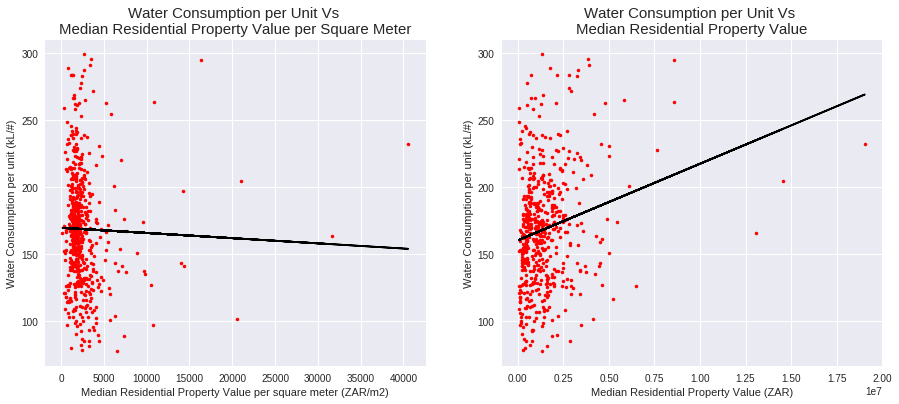

In [125]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Water Consumption vs Absolute Price
pl.subplot(121)
pl.plot(WaterVsPrice.Value15PerM2,WaterVsPrice.ConsPerUnit,".r", label="string")
#pl.plot(sort(WaterVsPrice.Value15PerM2),sort(lm.predict()),'-k')
pl.plot(WaterVsPrice['Value15PerM2'], lm2.predict(), 'k')

# Format Plot
pl.xlabel("Median Residential Property Value per square meter (ZAR/m2)")
pl.ylabel("Water Consumption per unit (kL/#)")
pl.title("Water Consumption per Unit Vs \n"\
         "Median Residential Property Value per Square Meter",
         fontsize=15)

# Plot Water Consumption Vs Price per square meter
pl.subplot(122)
pl.plot(WaterVsPrice.GV2015_VAL,WaterVsPrice.ConsPerUnit,".r", label="string")
pl.plot(WaterVsPrice['GV2015_VAL'], lm.predict(), 'k')

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)")
pl.ylabel("Water Consumption per unit (kL/#)")
pl.title("Water Consumption per Unit Vs \n"\
         "Median Residential Property Value",
         fontsize=15)
#pl.xlim(0,5000000)


#### Figure 7 and 8: Water Consumption per residential Unit and Median Property Value absolute and per squatre meter

Due to Square meterage being an issue in the city center but not outside of it, the square meters become irrellevant as you are paying less for proximity to facilities rather than size.

In [126]:
lm3 = smf.ols(formula = 'LogConsPerUnit ~ LogGV2015_VAL', data = WaterVsPrice).fit()
lm4 = smf.ols(formula = 'LogConsPerUnit ~ LogValue15PerM2', data = WaterVsPrice).fit()

In [127]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         LogConsPerUnit   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     27.74
Date:                Wed, 15 Nov 2017   Prob (F-statistic):           1.98e-07
Time:                        21:29:53   Log-Likelihood:                -18.860
No. Observations:                 566   AIC:                             41.72
Df Residuals:                     564   BIC:                             50.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         4.2860      0.154     27.799      0.000         3.983     4.589
LogGV2015_VAL     0.0587      0.011      5.267      0.000         0.037     0.081
==============================================================================
Omnibus:                        8.956   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.914
Skew:                          -0.300   Prob(JB):                       0.0116
Kurtosis:                       3.138   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         LogConsPerUnit   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     7.221
Date:                Wed, 15 Nov 2017   Prob (F-statistic):            0.00742
Time:                        21:29:53   Log-Likelihood:                -28.846
No. Observations:                 566   AIC:                             61.69
Df Residuals:                     564   BIC:                             70.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           5.4507      0.132     41.167      0.000         5.191     5.711
LogValue15PerM2    -0.0466      0.017     -2.687      0.007        -0.081    -0.013
==============================================================================
Omnibus:                        4.483   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.363
Skew:                          -0.213   Prob(JB):                        0.113
Kurtosis:                       3.056   Cond. No.                         96.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

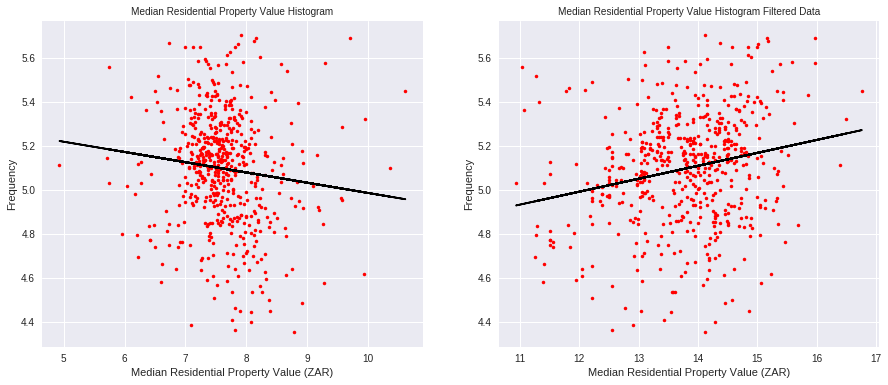

In [129]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Water Consumption vs Absolute Price
pl.subplot(121)
pl.plot(WaterVsPrice.LogValue15PerM2,WaterVsPrice.LogConsPerUnit,".r", label="string")
#pl.plot(sort(WaterVsPrice.Value15PerM2),sort(lm.predict()),'-k')
pl.plot(WaterVsPrice['LogValue15PerM2'], lm4.predict(), 'k')

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value Histogram",fontsize=10,)

# Plot Water Consumption Vs Price per square meter
pl.subplot(122)
pl.plot(WaterVsPrice.LogGV2015_VAL,WaterVsPrice.LogConsPerUnit,".r", label="string")
pl.plot(WaterVsPrice['LogGV2015_VAL'], lm3.predict(), 'k')

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)")
pl.ylabel("Frequency")
pl.title("Median Residential Property Value Histogram Filtered Data",fontsize=10,)
#pl.xlim(0,5000000)

#### Figure 7 and 8:  Logarithmic Water Consumption per residential Unit and Median Property Value absolute and per squatre meter

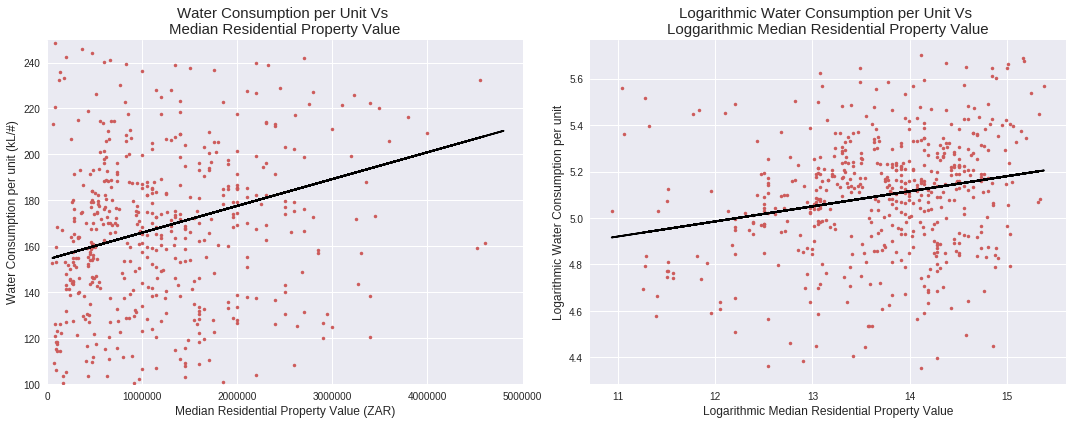

In [95]:
#Set total figure size
pl.figure(figsize=(15,6))

# Plot Water Consumption Vs Price per square meter
pl.subplot(121)
pl.plot(WaterVsPrice.GV2015_VAL,WaterVsPrice.ConsPerUnit,".",
        color='IndianRed', label="string")
pl.plot(WaterVsPrice['GV2015_VAL'], lm.predict(), 'k')

# Format Plot
pl.xlabel("Median Residential Property Value (ZAR)",
          fontsize=12)
pl.ylabel("Water Consumption per unit (kL/#)",
          fontsize=12)
pl.title("Water Consumption per Unit Vs \n"\
         "Median Residential Property Value",
         fontsize=15)
pl.ylim(100,250)
pl.xlim(0,5000000)

# Plot Water Consumption Vs Price per square meter
pl.subplot(122)
pl.plot(WaterVsPrice.LogGV2015_VAL,WaterVsPrice.LogConsPerUnit,".",
        color='IndianRed', label="string")
pl.plot(WaterVsPrice['LogGV2015_VAL'], lm3.predict(), 'k')

# Format Plot
pl.xlabel("Logarithmic Median Residential Property Value",
          fontsize=12)
pl.ylabel("Logarithmic Water Consumption per unit",
          fontsize=12)
pl.title("Logarithmic Water Consumption per Unit Vs \n"\
         "Loggarithmic Median Residential Property Value",
         fontsize=15)

pl.tight_layout()

#### Figure 9 and 10: Water Consumption per Residential Unit Vs Median Residential Property Value for the Cty of Cape Town
Note that there appears to be some linear correlation, although the data is scatter and potentially could be measured against actual income per area and Water Consumption per person if the data sets were available to imporve analysis. 